In [2]:
import numpy as np
import sys 
import sys
sys.path.append('/Users/glover.co/Documents/laszlo/NetDesign/scripts')
import assembly_tree as at
sys.path.append('/Users/glover.co/Documents/laszlo/NetDesign/scripts')
import mcmc 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
import json
import os
import treelib
import pandas as pd

In [3]:
protein_path = '../data/protein_complex/proteins'
human_prot = os.listdir(protein_path+'/human/treefiles/')
mouse_prot = os.listdir(protein_path+'/mouse/treefiles/')
yeast_prot = os.listdir(protein_path+'/yeast/treefiles/')

FileNotFoundError: [Errno 2] No such file or directory: '../data/protein_complex/proteins/human/treefiles/'

In [258]:
human_prot_stats = {}
mouse_prot_stats = {}
yeast_prot_stats = {}
for prot in human_prot:
    if prot.endswith('.txt'):
        with open(protein_path+'/human/treefiles/'+prot, 'r') as f:
            data = np.loadtxt(f, delimiter=',',skiprows=1)
            basename = prot.split('_')[0]
            human_prot_stats[basename] = data

for prot in mouse_prot:
    if prot.endswith('.txt'):
        with open(protein_path+'/mouse/treefiles/'+prot, 'r') as f:
            data = np.loadtxt(f, delimiter=',',skiprows=1)
            basename = prot.split('_')[0]
            mouse_prot_stats[basename] = data

for prot in yeast_prot:
    if prot.endswith('.txt'):
        with open(protein_path+'/yeast/treefiles/'+prot, 'r') as f:
            data = np.loadtxt(f, delimiter=',',skiprows=1)
            basename = prot.split('_')[0]
            yeast_prot_stats[basename] = data


In [5]:
human_prot_stats['CPX-1919']

array([5.600000e-01, 3.000000e+00, 6.439461e+03])

In [6]:
with open(protein_path + '/human/treefiles/CPX-1919_tree.json', 'r') as f:
    tree = json.load(f)

In [35]:
len(tree)

3

In [55]:
target = nx.read_edgelist(protein_path + '/human/edgefiles/CPX-1919.edge',nodetype=int)
X = np.loadtxt(protein_path + '/human/Xfiles/X_CPX-1919.txt')
O = at.extract_O(target,X)
capacity = at.extract_deg_cap(target,X).reshape(-1)

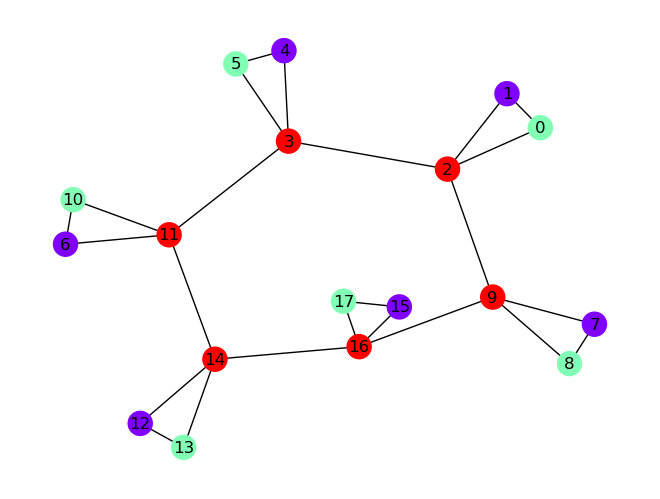

In [28]:
at.draw_network(target,X,with_labels=True)

In [68]:
def read_json_tree(json_tree):
    """
    Read JSON tree into treelib object

    Parameters
    ----------
    json_tree : str
        Path to the JSON file containing the tree structure
    
    Returns
    -------
    tree : treelib.Tree
        A treelib tree object representing the structure
    """
    def add_children(tree,parent,children):
        """
        Recursively add children to the tree
        
        Parameters
        ----------
        tree : treelib.Tree
            The tree to which children will be added
        parent : str
            The identifier of the parent node
        children : list
            List of child nodes to be added under the parent
        """
        for child in children:
            node_name = list(child.keys())[0]
            tree.create_node(tag=node_name, identifier=node_name, data=child[node_name]['data'], parent=parent)
            if 'children' in child[node_name]:
                add_children(tree, node_name, child[node_name]['children'])

    with open(json_tree, 'r') as f:
        data = json.load(f)
    tree_list = []
    for tree_data in data:
        root = list(tree_data.keys())[0]
        tree_data[root]['data']
        tree = treelib.Tree()
        tree.create_node(tag=root, identifier=root, data=tree_data[root]['data'])
        children = tree_data[root]['children']
        add_children(tree, root, children)
        tree_list.append(tree)
    return tree_list

In [67]:
tree[0]

{'0': {'children': [{'1': {'children': [{'37': {'children': [{'47': {'data': [6,
            8]}},
         {'48': {'data': [16]}}],
        'data': [6, 8, 16]}},
      {'38': {'data': [14]}}],
     'data': [6, 8, 14, 16]}},
   {'2': {'children': [{'43': {'children': [{'45': {'data': [4, 10]}},
         {'46': {'data': [13]}}],
        'data': [4, 10, 13]}},
      {'44': {'data': [2]}}],
     'data': [2, 4, 10, 13]}},
   {'3': {'children': [{'41': {'data': [0, 17]}}, {'42': {'data': [9, 12]}}],
     'data': [0, 9, 12, 17]}},
   {'4': {'children': [{'33': {'children': [{'35': {'data': [3, 5]}},
         {'36': {'data': [11]}}],
        'data': [3, 5, 11]}},
      {'34': {'data': [1]}}],
     'data': [1, 3, 5, 11]}},
   {'5': {'data': [7, 15]}}],
  'data': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]},
 'success': 1}

In [69]:
tree_list = read_json_tree(protein_path + '/human/treefiles/CPX-1919_tree.json')
tree_list[0].show()

0
├── 1
│   ├── 37
│   │   ├── 47
│   │   └── 48
│   └── 38
├── 2
│   ├── 43
│   │   ├── 45
│   │   └── 46
│   └── 44
├── 3
│   ├── 41
│   └── 42
├── 4
│   ├── 33
│   │   ├── 35
│   │   └── 36
│   └── 34
└── 5



In [98]:
def draw_guided_assembly(X,O,capacity,tree,**kwargs):
    """
    Draws a guided assembly tree with the given parameters.
    """
    # Get depth of tree
    depth = tree.depth()
    # Get number of leaves
    leaves = tree.leaves()
    num_leaves = len(leaves)
    depth_order = [tree.depth(node=n) for n in tree.all_nodes()]
    depth_idx = np.argsort(depth_order)[::-1]

    # Create subplots where each row has the number of subplots as there are nodes of that depth
    import matplotlib.gridspec as gridspec

    # Create a figure
    fig = plt.figure(figsize=kwargs.get('figsize', (20, 15)), dpi=kwargs.get('dpi', 100))

    # Create a GridSpec layout based on the depth of the tree
    gs = gridspec.GridSpec(depth + 1, num_leaves, figure=fig)

    # Create axes for each node at the corresponding depth
    ax = []
    for d in range(depth):
        nodes_at_depth = [n for n in tree.all_nodes() if tree.depth(node=n) == d]
        row_axes = [fig.add_subplot(gs[d, i]) for i in range(len(nodes_at_depth))]
        ax.append(row_axes)
    
    # Add a box around each subplot
    for row_axes in ax:
        for subplot in row_axes:
            subplot.spines['top'].set_visible(True)
            subplot.spines['right'].set_visible(True)
            subplot.spines['bottom'].set_visible(True)
            subplot.spines['left'].set_visible(True)
            subplot.spines['top'].set_color('black')
            subplot.spines['right'].set_color('black')
            subplot.spines['bottom'].set_color('black')
            subplot.spines['left'].set_color('black')
    
    # Iterate through the depths in reverse order (bottom to top)
    for d in range(depth - 1, -1, -1):
        nodes_at_depth = [n for n in tree.all_nodes() if tree.depth(node=n) == d]
        for i, node in enumerate(nodes_at_depth):
            initial_graph = nx.Graph()
            initial_graph.add_nodes_from(node.data)
            if len(node.data) != 1:
                A_flat, edges = at.find_optimal_edge_count(X, O, capacity, initial_graph=initial_graph, solution=True, ret_edges=True)
                initial_graph.add_edges_from(edges)
            at.draw_network(initial_graph, X, ax=ax[d][i], with_labels=True)
            
    # for d in range(depth - 1, -1, -1):
    #     nodes_at_depth = [n for n in tree.all_nodes() if tree.depth(node=n) == d]
    #     for i, node in enumerate(nodes_at_depth):
    #         initial_graph = nx.Graph()
    #         initial_graph.add_nodes_from(node.data)
    #         if len(node.data) != 1:
    #             A_flat, edges = at.find_optimal_edge_count(X, O, capacity, initial_graph=initial_graph, solution=True, ret_edges=True)
    #             initial_graph.add_edges_from(edges)
    #         at.draw_network(initial_graph, X, ax=ax[d][i], with_labels=True)

    

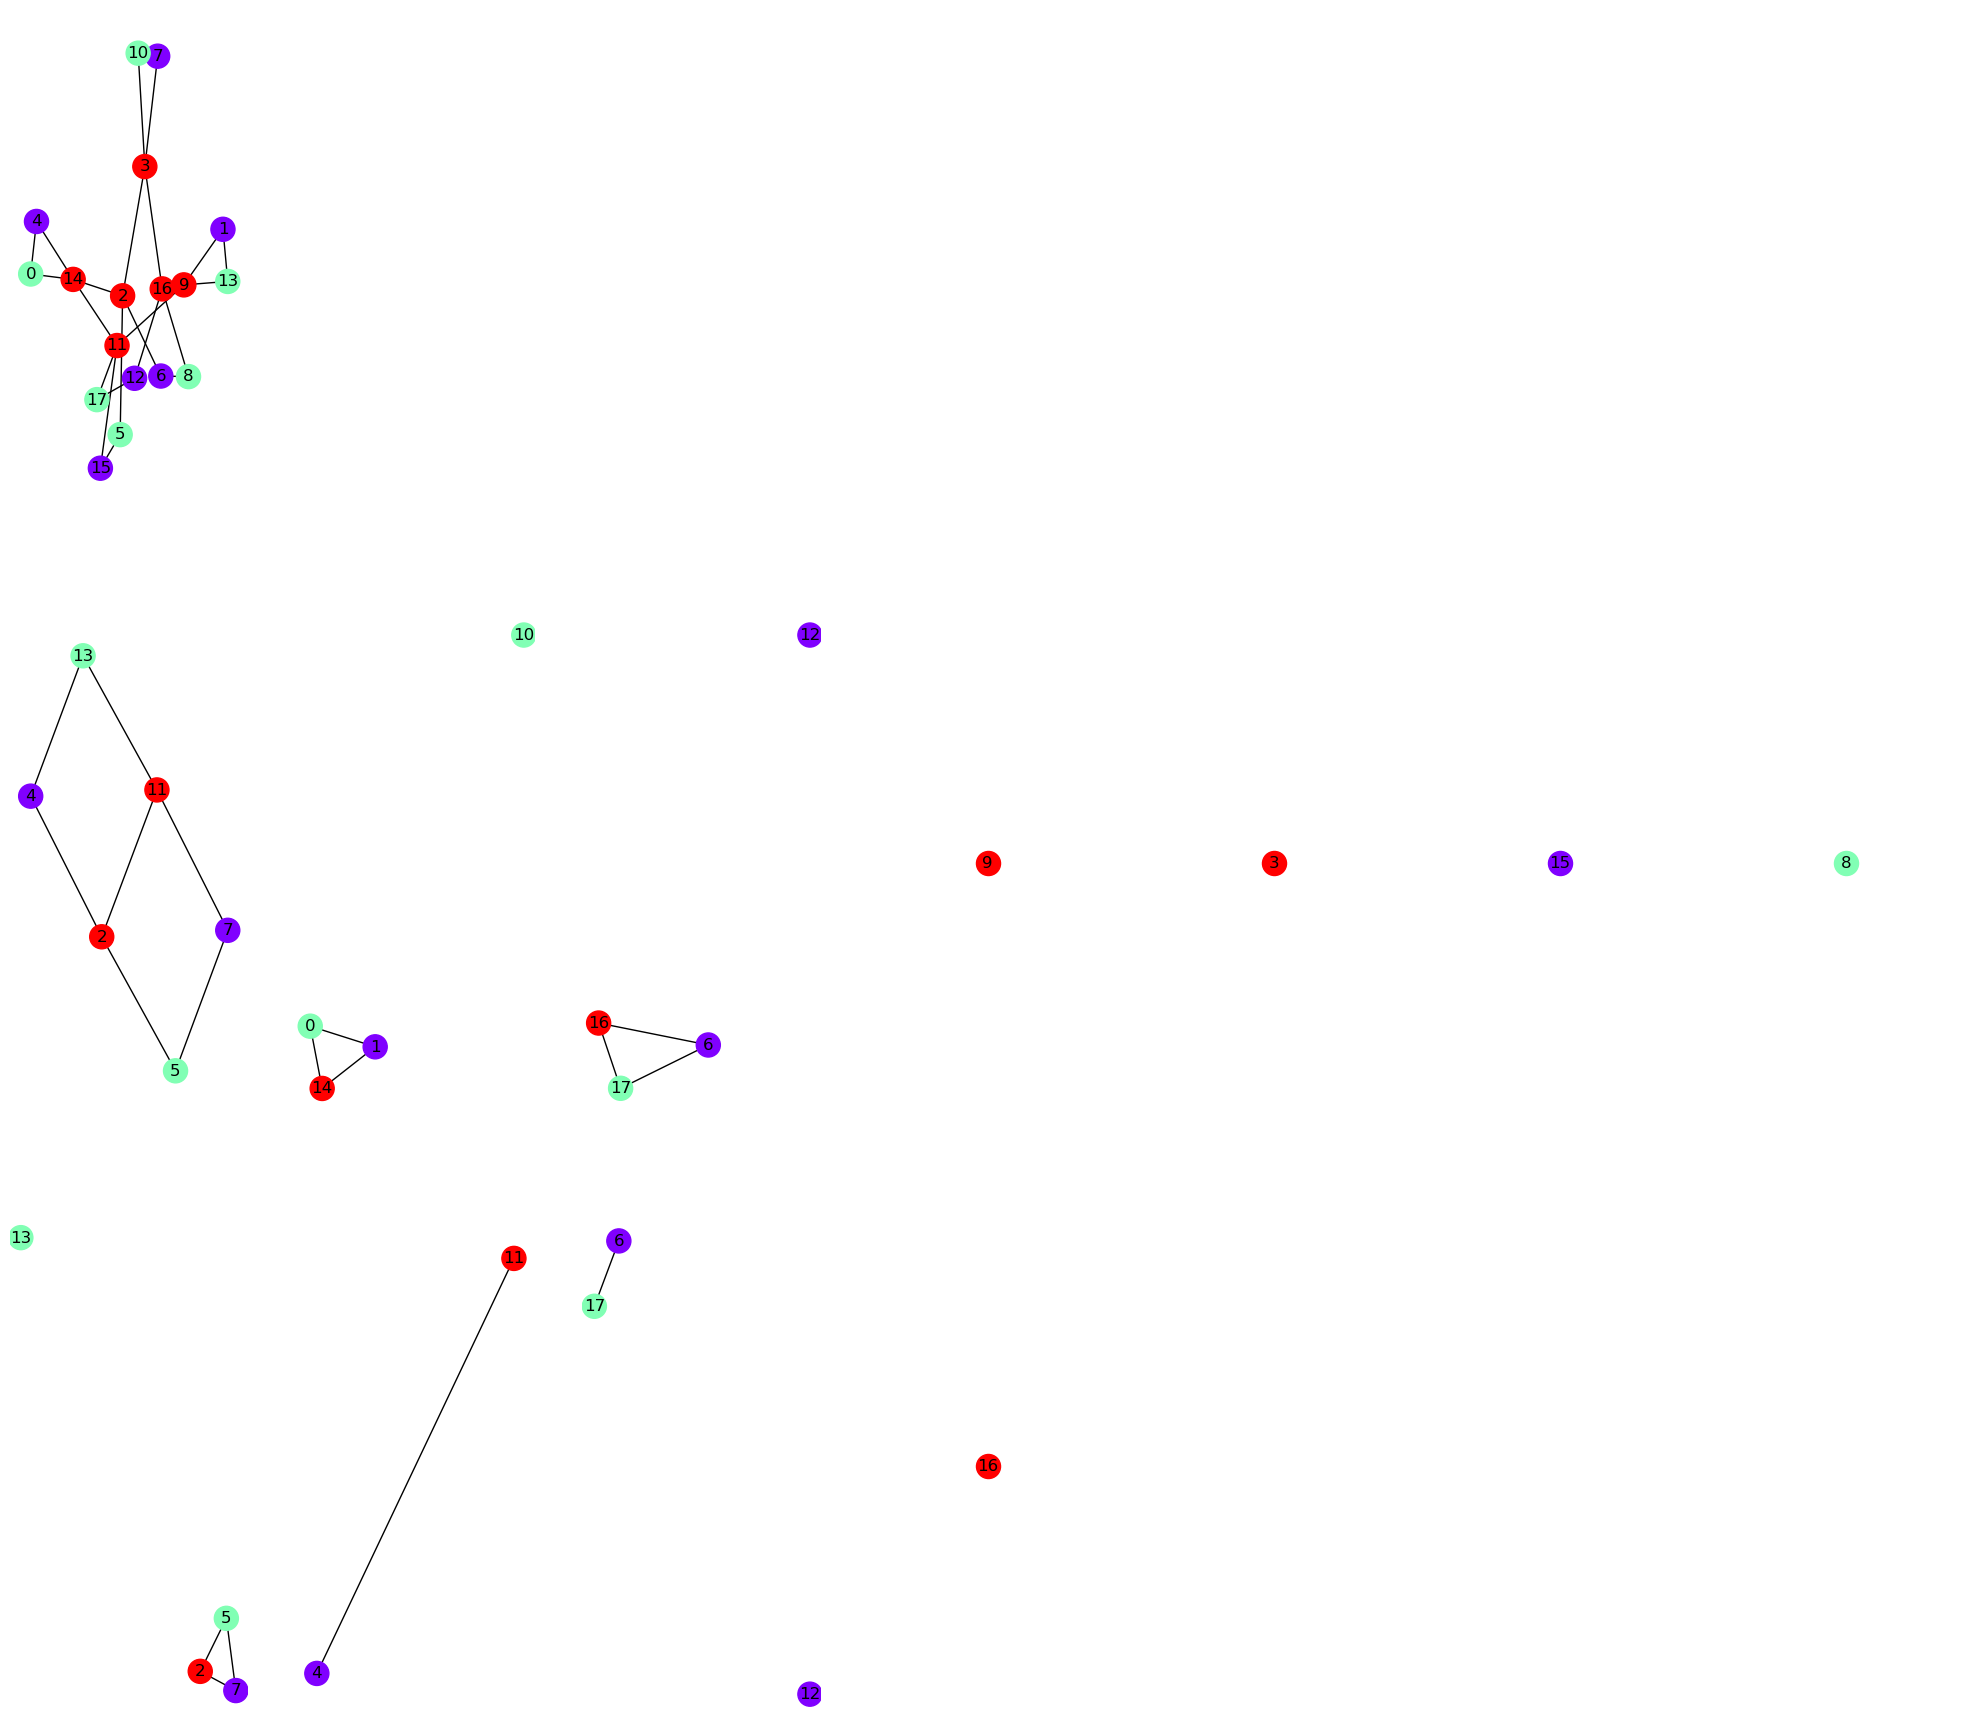

In [102]:
draw_guided_assembly(X,O,capacity,tree_list[2],figsize=(40,30),dpi=100)

In [62]:
import time
start = time.time()
for i in range(10000000000):
    x = True
time.time() - start

KeyboardInterrupt: 

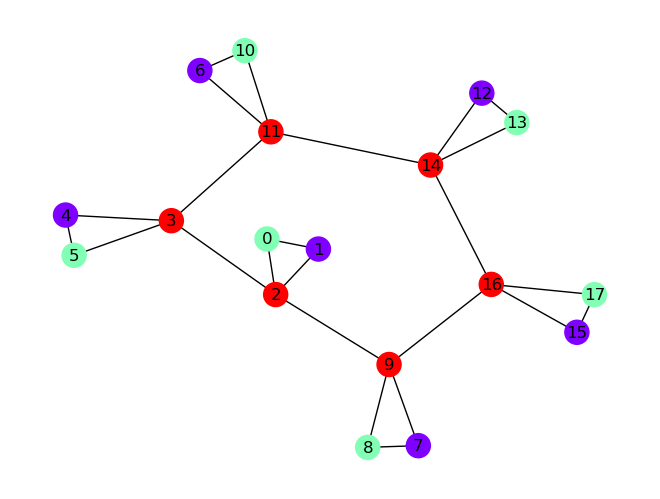

In [30]:
at.draw_network(target,X,with_labels=True)

In [31]:
initial_graph = nx.Graph()
initial_graph.add_nodes_from(list(target.nodes())  )
initial_graph.add_edges_from(list(target.edges()))
initial_graph.remove_edges_from([(2,3),(3,11),(11,14),(14,16),(16,9),(2,9)])
at.find_optimal_edge_count(X,O,capacity.reshape(-1),initial_graph=initial_graph)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1., -0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [32]:
p = at.prob_dist(X,O,capacity=capacity.reshape(-1),initial_graph=initial_graph,max_iters=1000)

In [34]:
(p[0]/p[0].sum())[0]

np.float64(0.871)

In [33]:
for i in range(len(p[1])):
    if nx.is_isomorphic(p[1][i],target):
        print(i)

0


In [259]:
# Get proteins where the depth is at least 1
human_prots_depth_1 = []
human_stats_depth_1 = np.empty(shape=(0,3))

for prot in human_prot_stats:
    if human_prot_stats[prot][1] >= 1:
        try:
            human_stats_depth_1 = np.vstack((human_stats_depth_1,human_prot_stats[prot]))
            human_prots_depth_1.append(prot)

        except:
            continue
mouse_prots_depth_1 = []
mouse_stats_depth_1 = np.empty(shape=(0,3))
for prot in mouse_prot_stats:
    if mouse_prot_stats[prot][1] >= 1:
        try:
            mouse_stats_depth_1 = np.vstack((mouse_stats_depth_1,mouse_prot_stats[prot]))
            mouse_prots_depth_1.append(prot)

        except:
            continue
yeast_prots_depth_1 = []
yeast_stats_depth_1 = np.empty(shape=(0,3))
for prot in yeast_prot_stats:
    if yeast_prot_stats[prot][1] >= 1:
        try:
            yeast_stats_depth_1 = np.vstack((yeast_stats_depth_1,yeast_prot_stats[prot]))
            yeast_prots_depth_1.append(prot)

        except:
            continue
        


In [260]:
# Get proteins where the depth is at least 1
human_prots_depth_0 = []
human_stats_depth_0 = np.empty(shape=(0,3))
for prot in human_prot_stats:
    if human_prot_stats[prot][1] >= 0:
        try:
            human_stats_depth_0 = np.vstack((human_stats_depth_0,human_prot_stats[prot]))
            human_prots_depth_0.append(prot)

        except:
            continue
mouse_prots_depth_0 = []
mouse_stats_depth_0 = np.empty(shape=(0,3))
for prot in mouse_prot_stats:
    if mouse_prot_stats[prot][1] >= 0:
        try:
            mouse_stats_depth_0 = np.vstack((mouse_stats_depth_0,mouse_prot_stats[prot]))
            mouse_prots_depth_0.append(prot)

        except:
            continue
yeast_prots_depth_0 = []
yeast_stats_depth_0 = np.empty(shape=(0,3))
for prot in yeast_prot_stats:
    if yeast_prot_stats[prot][1] >= 0:
        try:
            yeast_stats_depth_0 = np.vstack((yeast_stats_depth_0,yeast_prot_stats[prot]))
            yeast_prots_depth_0.append(prot)

        except:
            continue

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_66913/202407746.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('$P(G\mid T)$',fontsize=12)


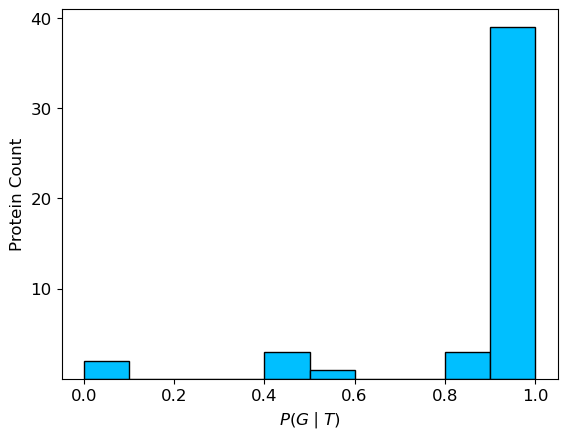

In [285]:
combined_stats = np.concatenate([human_stats_depth_1[:, 0], mouse_stats_depth_1[:, 0], yeast_stats_depth_1[:, 0]])
plt.hist(combined_stats, alpha=1,color='deepskyblue', bins=10, density=False, edgecolor='black')
plt.xlabel('$P(G\mid T)$',fontsize=12)
plt.xticks([0.0,.2,.4,.6,.8,1.0],['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=12)
plt.yticks([10,20,30,40],['10','20','30','40'],fontsize=12)
plt.ylabel('Protein Count',fontsize=12)
# plt.title('Distribution of $P(G\mid T)$ for GA proteins')
plt.savefig('guided_assembly_p_distribution_protein.png', dpi=300, bbox_inches='tight')
plt.show()

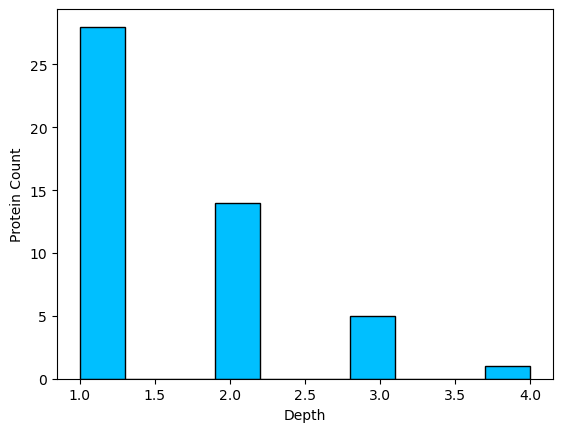

In [290]:
combined_stats = np.concatenate([human_stats_depth_1[:, 1], mouse_stats_depth_1[:, 1], yeast_stats_depth_1[:,1]])
plt.hist(combined_stats, alpha=1,color='deepskyblue', bins=10, density=False, edgecolor='black')
plt.xlabel('Depth')
plt.ylabel('Protein Count')
# plt.title('Distribution of Depth for Proteins')
plt.savefig('guided_assembly_depth_distribution_protein.png', dpi=300, bbox_inches='tight')
plt.show()

In [289]:
len(combined_stats[combined_stats == 1]) / len(combined_stats)

0.75

In [168]:
# Get diversity counts
num_types_human_depth_1 = []
num_nodes_human_depth_1 = []
largest_cycle_human_depth_1 = []
for prot in human_prots_depth_1:
    # Get X
    X = np.loadtxt(protein_path + '/human/Xfiles/X_'+prot+'.txt')
    num_types_human_depth_1.append(X.shape[1])
    num_nodes_human_depth_1.append(X.shape[0])
    # Get largest disjoint cycle
    G = nx.read_edgelist(protein_path + '/human/edgefiles/'+prot+'.edge', nodetype=int)
    cycle_basis = nx.cycle_basis(G)
    largest_cycle = max(cycle_basis, key=len) if cycle_basis else []
    largest_cycle_human_depth_1.append(len(largest_cycle))
num_types_human_depth_1 = np.array(num_types_human_depth_1)
num_nodes_human_depth_1 = np.array(num_nodes_human_depth_1)
largest_cycle_human_depth_1 = np.array(largest_cycle_human_depth_1)
num_types_mouse_depth_1 = []
num_nodes_mouse_depth_1 = []
largest_cycle_mouse_depth_1 = []
for prot in mouse_prots_depth_1:
    # Get X
    X = np.loadtxt(protein_path + '/mouse/Xfiles/X_'+prot+'.txt')
    num_types_mouse_depth_1.append(X.shape[1])
    num_nodes_mouse_depth_1.append(X.shape[0])

    # Get largest disjoint cycle
    G = nx.read_edgelist(protein_path + '/mouse/edgefiles/'+prot+'.edge', nodetype=int)
    cycle_basis = nx.cycle_basis(G)
    largest_cycle = max(cycle_basis, key=len) if cycle_basis else []
    largest_cycle_mouse_depth_1.append(len(largest_cycle))
largest_cycle_mouse_depth_1 = np.array(largest_cycle_mouse_depth_1)
num_types_mouse_depth_1 = np.array(num_types_mouse_depth_1)
num_nodes_mouse_depth_1 = np.array(num_nodes_mouse_depth_1)
num_types_yeast_depth_1 = []
num_nodes_yeast_depth_1 = []
largest_cycle_yeast_depth_1 = []
for prot in yeast_prots_depth_1:
    # Get X
    X = np.loadtxt(protein_path + '/yeast/Xfiles/X_'+prot+'.txt')
    num_types_yeast_depth_1.append(X.shape[1])
    num_nodes_yeast_depth_1.append(X.shape[0])
    G = nx.read_edgelist(protein_path + '/yeast/edgefiles/'+prot+'.edge', nodetype=int)
    # Get largest disjoint cycle
    cycle_basis = nx.cycle_basis(G)
    largest_cycle = max(cycle_basis, key=len) if cycle_basis else []
    largest_cycle_yeast_depth_1.append(len(largest_cycle))
largest_cycle_yeast_depth_1 = np.array(largest_cycle_yeast_depth_1)
num_types_yeast_depth_1 = np.array(num_types_yeast_depth_1)
num_nodes_yeast_depth_1 = np.array(num_nodes_yeast_depth_1)

In [194]:
# Get diversity counts for depth >= 0
num_types_human_depth_0 = []
num_nodes_human_depth_0 = []
largest_cycle_human_depth_0 = []
for prot in human_prots_depth_0:
    # Get X
    X = np.loadtxt(protein_path + '/human/Xfiles/X_'+prot+'.txt')
    num_types_human_depth_0.append(X.shape[1])
    num_nodes_human_depth_0.append(X.shape[0])
    # Get largest disjoint cycle
    G = nx.read_edgelist(protein_path + '/human/edgefiles/'+prot+'.edge', nodetype=int)
    cycle_basis = nx.cycle_basis(G)
    largest_cycle = max(cycle_basis, key=len) if cycle_basis else []
    largest_cycle_human_depth_0.append(len(largest_cycle))
num_types_human_depth_0 = np.array(num_types_human_depth_0)
num_nodes_human_depth_0 = np.array(num_nodes_human_depth_0)
largest_cycle_human_depth_0 = np.array(largest_cycle_human_depth_0)

num_types_mouse_depth_0 = []
num_nodes_mouse_depth_0 = []
largest_cycle_mouse_depth_0 = []
for prot in mouse_prots_depth_0:
    # Get X
    X = np.loadtxt(protein_path + '/mouse/Xfiles/X_'+prot+'.txt')
    num_types_mouse_depth_0.append(X.shape[1])
    num_nodes_mouse_depth_0.append(X.shape[0])
    # Get largest disjoint cycle
    G = nx.read_edgelist(protein_path + '/mouse/edgefiles/'+prot+'.edge', nodetype=int)
    cycle_basis = nx.cycle_basis(G)
    largest_cycle = max(cycle_basis, key=len) if cycle_basis else []
    largest_cycle_mouse_depth_0.append(len(largest_cycle))
largest_cycle_mouse_depth_0 = np.array(largest_cycle_mouse_depth_0)
num_types_mouse_depth_0 = np.array(num_types_mouse_depth_0)
num_nodes_mouse_depth_0 = np.array(num_nodes_mouse_depth_0)

num_types_yeast_depth_0 = []
num_nodes_yeast_depth_0 = []
largest_cycle_yeast_depth_0 = []
for prot in yeast_prots_depth_0:
    # Get X
    X = np.loadtxt(protein_path + '/yeast/Xfiles/X_'+prot+'.txt')
    num_types_yeast_depth_0.append(X.shape[1])
    num_nodes_yeast_depth_0.append(X.shape[0])
    # Get largest disjoint cycle
    G = nx.read_edgelist(protein_path + '/yeast/edgefiles/'+prot+'.edge', nodetype=int)
    cycle_basis = nx.cycle_basis(G)
    largest_cycle = max(cycle_basis, key=len) if cycle_basis else []
    largest_cycle_yeast_depth_0.append(len(largest_cycle))
largest_cycle_yeast_depth_0 = np.array(largest_cycle_yeast_depth_0)
num_types_yeast_depth_0 = np.array(num_types_yeast_depth_0)
num_nodes_yeast_depth_0 = np.array(num_nodes_yeast_depth_0)

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_66913/1663443268.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 1')


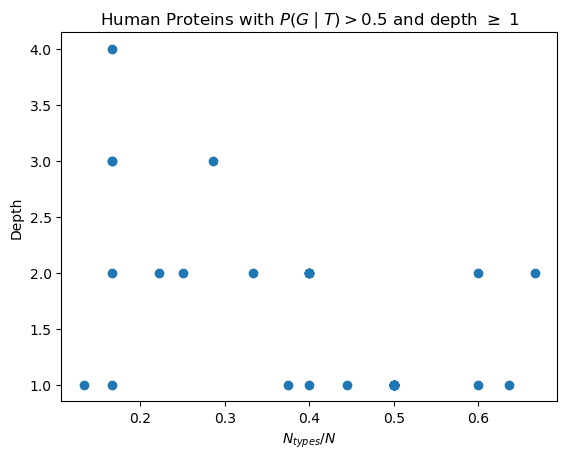

In [190]:
plt.plot(num_types_human_depth_1[np.where(human_stats_depth_1[:,0]>.5)[0]]/num_nodes_human_depth_1[np.where(human_stats_depth_1[:,0]>.5)[0]],human_stats_depth_1[np.where(human_stats_depth_1[:,0]>.5)[0],1],'o')
plt.xlabel('$N_{types}/N$')
plt.ylabel('Depth')
plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 1')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_66913/2147912307.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 0')


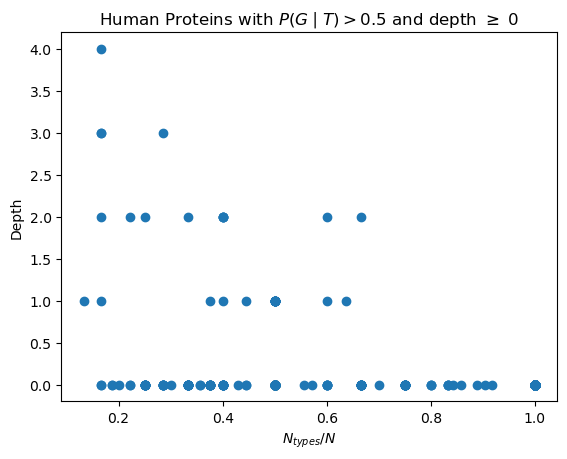

In [195]:
plt.plot(num_types_human_depth_0[np.where(human_stats_depth_0[:,0]>.5)[0]]/num_nodes_human_depth_0[np.where(human_stats_depth_0[:,0]>.5)[0]],human_stats_depth_0[np.where(human_stats_depth_0[:,0]>.5)[0],1],'o')
plt.xlabel('$N_{types}/N$')
plt.ylabel('Depth')
plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 0')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_66913/1771898752.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 1')


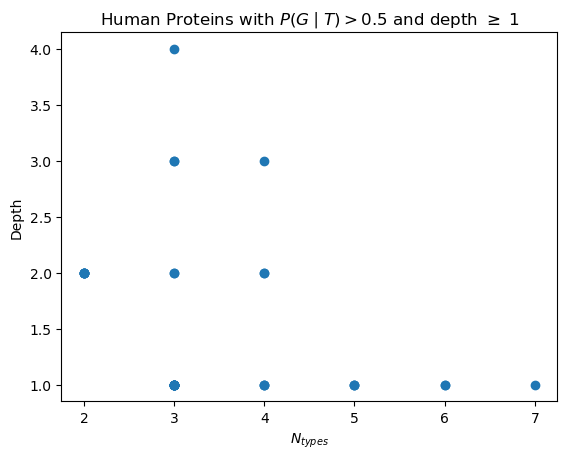

In [197]:
plt.plot(num_types_human_depth_1[np.where(human_stats_depth_1[:,0]>.5)[0]],human_stats_depth_1[np.where(human_stats_depth_1[:,0]>.5)[0],1],'o')
plt.xlabel('$N_{types}$')
plt.ylabel('Depth')
plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 1')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_66913/1573211527.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 0')


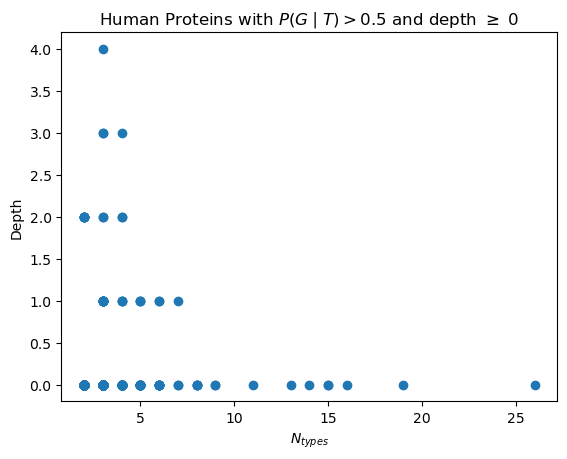

In [198]:
plt.plot(num_types_human_depth_0[np.where(human_stats_depth_0[:,0]>.5)[0]],human_stats_depth_0[np.where(human_stats_depth_0[:,0]>.5)[0],1],'o')
plt.xlabel('$N_{types}$')
plt.ylabel('Depth')
plt.title('Human Proteins with $P(G\mid T) > 0.5$ and depth $\geq$ 0')
plt.show()

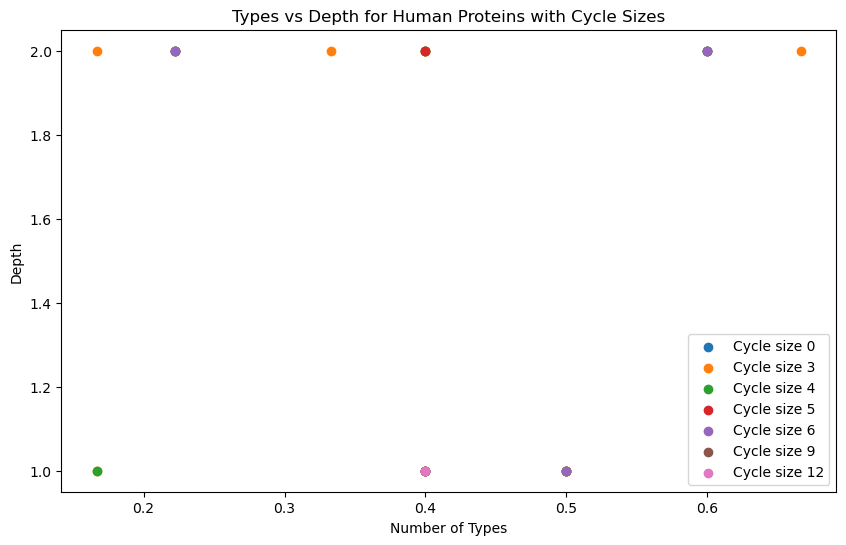

In [206]:
# Plot types vs depth for different cycle sizes
plt.figure(figsize=(10,6))
cycle_sizes = np.unique(largest_cycle_human_depth_1)
for cycle_size in cycle_sizes:
    indices = np.where(largest_cycle_human_depth_1 == cycle_size)[0]
    indices = np.where(human_stats_depth_1[indices, 0] >= .5)[0]
    plt.scatter(num_types_human_depth_1[indices]/num_nodes_human_depth_1[indices], human_stats_depth_1[indices, 1], label=f'Cycle size {cycle_size}')
plt.xlabel('Number of Types')
plt.ylabel('Depth')
plt.title('Types vs Depth for Human Proteins with Cycle Sizes')
plt.legend()
plt.show()

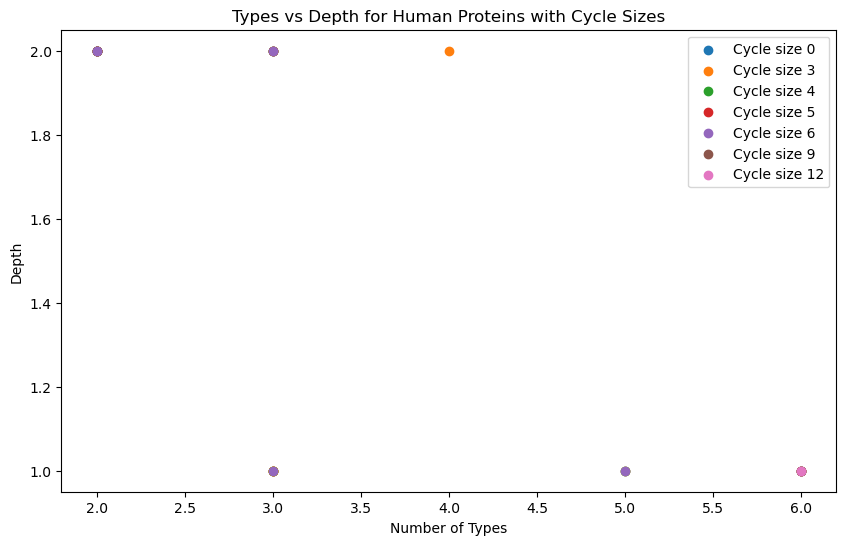

In [182]:
# Plot types vs depth for different cycle sizes
plt.figure(figsize=(10,6))
cycle_sizes = np.unique(largest_cycle_human_depth_1)
for cycle_size in cycle_sizes:
    indices = np.where(largest_cycle_human_depth_1 == cycle_size)[0]
    indices = np.where(human_stats_depth_1[indices, 0] >= .5)[0]
    plt.scatter(num_types_human_depth_1[indices], human_stats_depth_1[indices, 1], label=f'Cycle size {cycle_size}')
plt.xlabel('Number of Types')
plt.ylabel('Depth')
plt.title('Types vs Depth for Human Proteins with Cycle Sizes')
plt.legend()
plt.show()

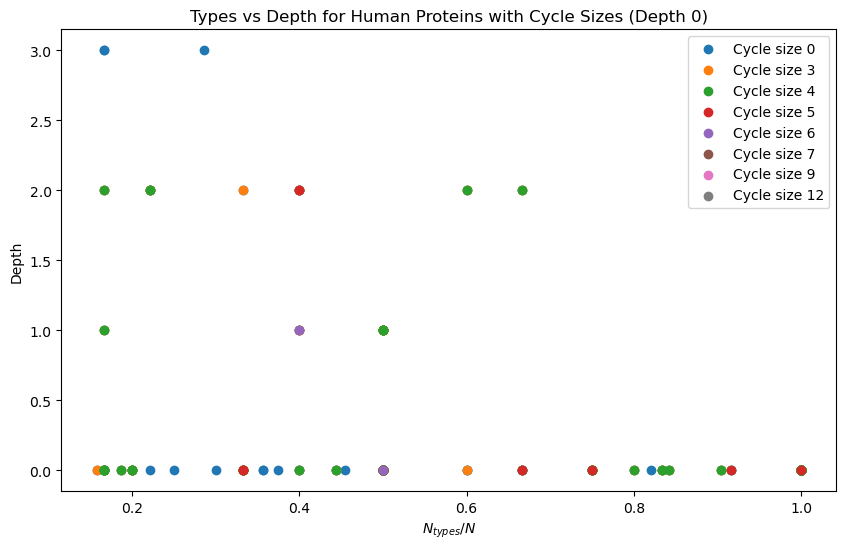

In [ ]:
# Plot types vs depth for different cycle sizes
plt.figure(figsize=(10,6))
cycle_sizes = np.unique(largest_cycle_human_depth_0)
for cycle_size in cycle_sizes:
    indices = np.where(largest_cycle_human_depth_0 == cycle_size)[0]
    indices = np.where(human_stats_depth_0[indices, 0] == 1)[0]
    plt.scatter(num_types_human_depth_0[indices]/num_nodes_human_depth_0[indices], human_stats_depth_0[indices, 1], label=f'Cycle size {cycle_size}')
plt.xlabel('$N_{types}/N$')
plt.ylabel('Depth')
plt.title('Types vs Depth for Human Proteins with Cycle Sizes (Depth 0)')
plt.legend()
plt.show()

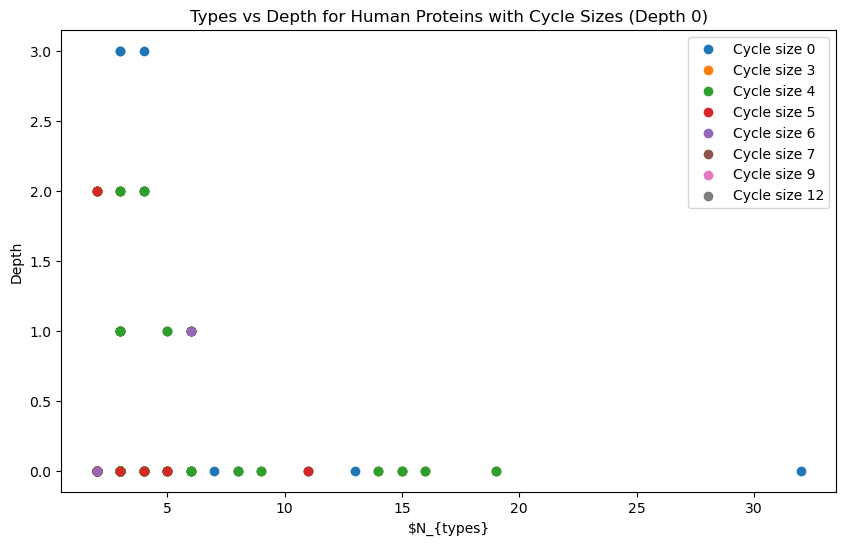

In [208]:
# Plot types vs depth for different cycle sizes
plt.figure(figsize=(10,6))
cycle_sizes = np.unique(largest_cycle_human_depth_0)
for cycle_size in cycle_sizes:
    indices = np.where(largest_cycle_human_depth_0 == cycle_size)[0]
    indices = np.where(human_stats_depth_0[indices, 0] == 1)[0]
    plt.scatter(num_types_human_depth_0[indices], human_stats_depth_0[indices, 1], label=f'Cycle size {cycle_size}')
plt.xlabel('$N_{types}')
plt.ylabel('Depth')
plt.title('Types vs Depth for Human Proteins with Cycle Sizes (Depth 0)')
plt.legend()
plt.show()

In [213]:
molecule_path = '../data/Molecules'
molecules = os.listdir(molecule_path+'/treefiles/')
mol_stats = {}
for mole in molecules:
    if mole.endswith('.txt'):
        with open(molecule_path+'/treefiles/'+mole, 'r') as f:
            data = np.loadtxt(f, delimiter=',',skiprows=1)
            basename = mole.split('t')[0][:-1]
            mol_stats[basename] = data

In [214]:
mol_stats

{'CID_24456': array([  1.        ,   0.        , 717.80483413]),
 'CID_24266': array([  1.        ,   0.        , 301.23747277]),
 'CID_10026': array([-3.91202301,  2.        ]),
 'CID_168924': array([1.0000000e+00, 0.0000000e+00, 1.0952262e+03]),
 'CID_5453': array([1.00000000e+00, 1.00000000e+00, 2.15828812e+03]),
 'CID_10197702': array([  -3.91202301,    2.        , 1773.26559901]),
 'CID_25960': array([  1.        ,   0.        , 310.46543789]),
 'CID_11029': array([  1.        ,   0.        , 234.92890167]),
 'CID_24393': array([  1.        ,   0.        , 364.38573146]),
 'CID_6374': array([  1.        ,   0.        , 299.47158003]),
 'CID_24439': array([  1.        ,   0.        , 784.04309464]),
 'CID_24424': array([  1.        ,   0.        , 324.13613582]),
 'CID_727': array([1.00000000e+00, 1.00000000e+00, 1.86973894e+03]),
 'CID_119432': array([  1.        ,   0.        , 233.12089705]),
 'CID_61745': array([1.        , 0.        , 0.56411338, 1.        ]),
 'CID_76957057':

In [215]:
# Get proteins where the depth is at least 1
molecule_depth_1 = []
molecule_stats_depth_1 = np.empty(shape=(0,3))

for mole in mol_stats:
    if mol_stats[mole][1] >= 1:
        try:
            molecule_stats_depth_1 = np.vstack((molecule_stats_depth_1,mol_stats[mole]))
            molecule_depth_1.append(mole)

        except:
            continue

(array([1., 0., 0., 0., 0., 0., 1., 1., 0., 2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

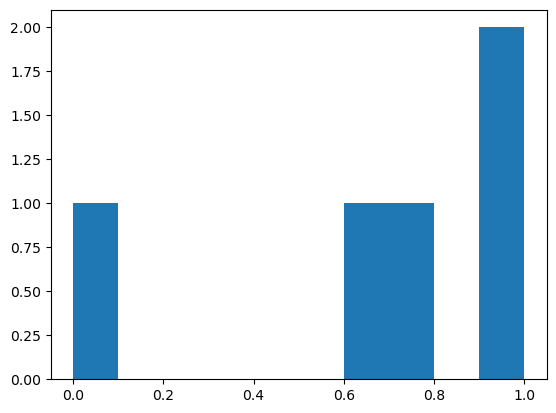

In [223]:
molecule_stats_depth_1[np.where(molecule_stats_depth_1[:,0]<0)[0],0] = 0
plt.hist(molecule_stats_depth_1[:,0])

In [221]:
molecule_stats_depth_1

array([[ 1.00000000e+00,  1.00000000e+00,  2.15828812e+03],
       [-3.91202301e+00,  2.00000000e+00,  1.77326560e+03],
       [ 1.00000000e+00,  1.00000000e+00,  1.86973894e+03],
       [ 7.32000000e-01,  2.00000000e+00,  2.15282840e+02],
       [ 6.40000000e-01,  3.00000000e+00,  4.22600023e+03]])

In [222]:
np.where(molecule_stats_depth_1[:,0]<0)[0]

array([1])

In [231]:
def smoothstep(x, lower=0.0, upper=1.0):
    """
    Smooth step function that transitions from 0 to 1 between lower and upper bounds.
    
    Parameters
    ----------
    x : float or np.ndarray
        Input value(s) to the smooth step function.
    lower : float, optional
        Lower bound of the transition (default is 0.0).
    upper : float, optional
        Upper bound of the transition (default is 1.0).
    
    Returns
    -------
    float or np.ndarray
        The output value(s) of the smooth step function.
    """
    x = np.clip((x - lower) / (upper - lower), 0.0, 1.0)
    return x * x * (3 - 2 * x)  # Smoothstep formula

In [245]:
def repeated_smoothstep(x):
    y = []
    new_x = []
    for i in range(10):
        y += (smoothstep(x + i * 10,lower=0,upper=10)+i).tolist()
        new_x += (x + i * 10).tolist()
    return np.array(new_x), np.array(y)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100, 100) and arg 2 with shape (1000, 100).

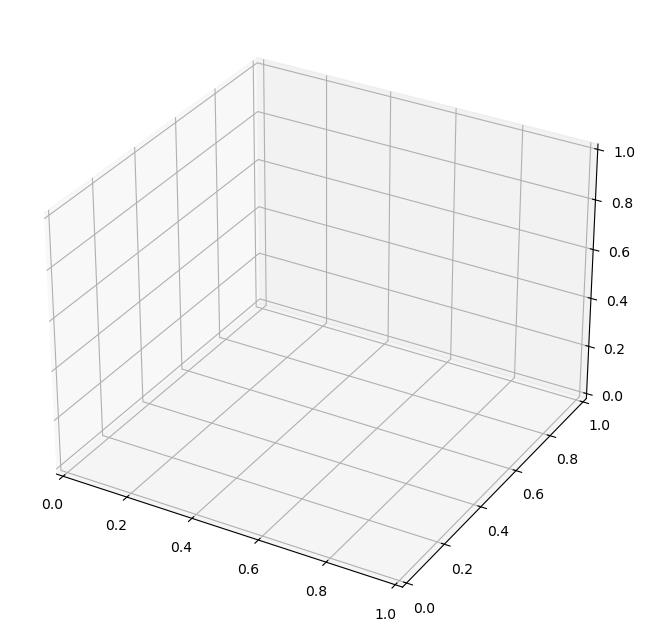

In [251]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
new_X, X_Z = repeated_smoothstep(X)
new_Y, Y_Z = repeated_smoothstep(Y)
Z = X_Z + Y_Z

# Adjust new_X and new_Y to match the original X and Y ranges
new_X = X
new_Y = Y

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(new_X, new_Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Smoothstep Transition')
plt.show()


In [255]:
cap = np.array([2,3,4])
O = np.ones((3,3))
(O*cap).T

array([[2., 2., 2.],
       [3., 3., 3.],
       [4., 4., 4.]])

In [291]:
import os

In [292]:
# Take .txt off of str


Signature: os.path.splitext(p)
Docstring:
Split the extension from a pathname.

Extension is everything from the last dot to the end, ignoring
leading dots.  Returns "(root, ext)"; ext may be empty.
File:      ~/Documents/laszlo/NetDesign/notebooks/<frozen posixpath>
Type:      function

In [4]:
protein_df = pd.read_csv('../data/proteins/protein_dataframe.csv')

In [5]:
protein_df_indiv_nodes = protein_df.groupby('basename')[['N','avg_k','cyclicity','node_symmetry','graph_density','diversity','degree_heterogeneity','clustering','Oness','N_types','largest_cycle','accuracy','min_depth']].mean()

In [6]:
mol_df = pd.read_csv('../data/Molecules/molecule_dataframe.csv')

In [7]:
mol_df_indiv_nodes = mol_df.groupby('basename')[['N','avg_k','cyclicity','node_symmetry','graph_density','diversity','degree_heterogeneity','clustering','Oness','N_types','largest_cycle','accuracy','min_depth']].mean()

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_10961/2699357139.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('$P(G\mid T)$', fontsize=28)


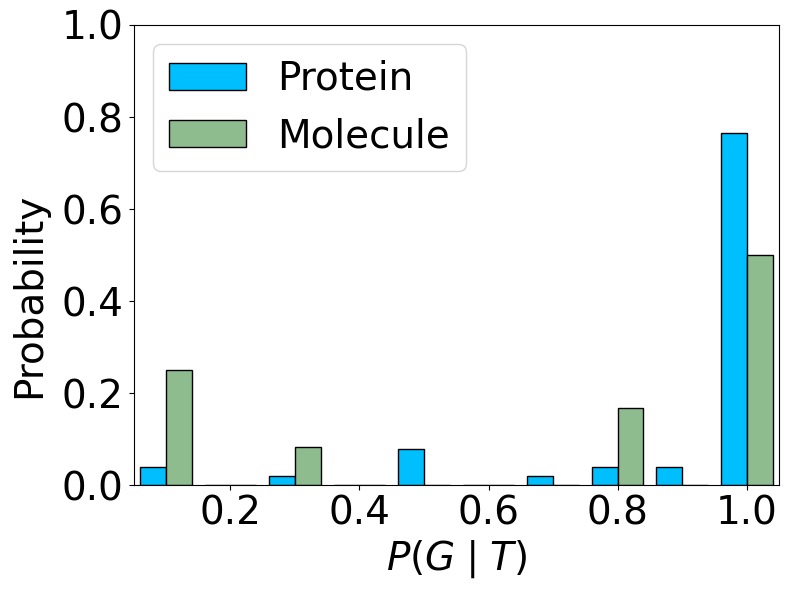

In [21]:
fig, ax1 = plt.subplots(figsize=(8,6))
# Plot the histogram for mol_df_indiv_nodes
mol_hist = mol_df_indiv_nodes[mol_df_indiv_nodes['min_depth'] > 0]['accuracy'].value_counts(bins=10, sort=False).sort_index()
protein_hist = protein_df_indiv_nodes[protein_df_indiv_nodes['min_depth'] > 0]['accuracy'].value_counts(bins=10, sort=False).sort_index()

# Normalize the histograms to probabilities
mol_hist_prob = mol_hist / mol_hist.sum()
protein_hist_prob = protein_hist / protein_hist.sum()

# Plot the histograms as probabilities
width = 0.4  # Width of the bars
protein_hist_prob.plot(kind='bar', ax=ax1, width=width, position=1, color='deepskyblue', edgecolor='black', label='Protein')
mol_hist_prob.plot(kind='bar', ax=ax1, width=width, position=0, color='darkseagreen', edgecolor='black', label='Molecule')

# Add labels and legend
fig.supylabel('Probability', color='k', fontsize=28)
ax1.set_xlabel('$P(G\mid T)$', fontsize=28)
ax1.legend(fontsize=28)
ax1.set_xticks([1,3,5,7,9],['0.2', '0.4', '0.6', '0.8', '1.0'],fontsize=28,rotation=0)
ax1.set_xlim(-0.5,9.5)
ax1.set_yticks([0,.2,.4,.6,.8,1.0],['0.0','0.2','0.4','0.6','0.8','1.0'],fontsize=28)

plt.tight_layout()
plt.savefig('guided_assembly_accuracy_distribution.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Protein Accuracy vs Diversity')

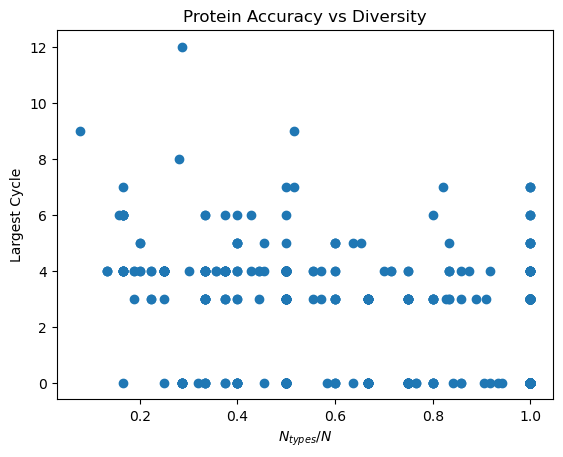

In [428]:
plt.plot(protein_df_indiv_nodes['diversity'],protein_df_indiv_nodes['largest_cycle'],'o')
plt.xlabel('$N_{types}/N$')
plt.ylabel('Largest Cycle')
plt.title('Protein Accuracy vs Diversity')

Text(0.5, 1.0, 'Molecule Accuracy vs Diversity')

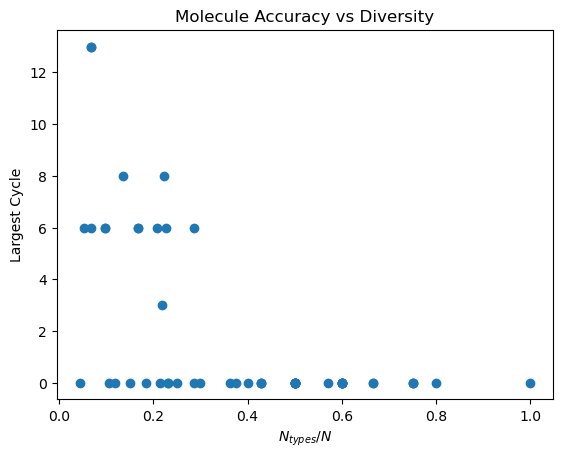

In [427]:
plt.plot(mol_df_indiv_nodes['diversity'],mol_df_indiv_nodes['largest_cycle'],'o')
plt.xlabel('$N_{types}/N$')
plt.ylabel('Largest Cycle')
plt.title('Molecule Accuracy vs Diversity')

/var/folders/8t/4z1vq2xd5790h0y5jrvphttr0000gp/T/ipykernel_10961/391558822.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0,1,2,3,4,5,6],fontsize=28)


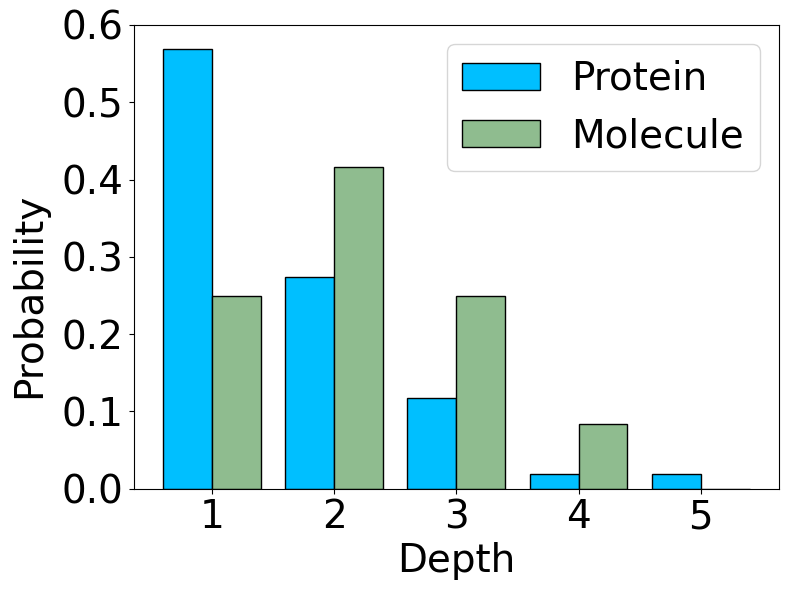

In [22]:
depths = [1, 2, 3, 4, 5]
protein_depth_counts = protein_df_indiv_nodes[protein_df_indiv_nodes['min_depth'].isin(depths)]['min_depth'].value_counts().sort_index()
molecule_depth_counts = mol_df_indiv_nodes[mol_df_indiv_nodes['min_depth'].isin(depths)]['min_depth'].value_counts().sort_index()

# Normalize the counts to percentages
protein_depth_percentages = protein_depth_counts / protein_depth_counts.sum()
molecule_depth_percentages = np.append(molecule_depth_counts / molecule_depth_counts.sum(), 0)
# Bar plot for percentages
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.4  # Width of the bars

# Plot protein percentages
ax.bar([d - width / 2 for d in depths], protein_depth_percentages, width=width, color='deepskyblue', edgecolor='black', label='Protein')

# Plot molecule percentages
ax.bar([d + width / 2 for d in depths], molecule_depth_percentages, width=width, color='darkseagreen', edgecolor='black', label='Molecule')

# Add labels and legend
ax.set_xlabel('Depth', fontsize=28)
fig.supylabel('Probability', fontsize=28)
# ax.set_title('Percentage of Networks by Depth', fontsize=16)
ax.legend(fontsize=28)
ax.set_xticklabels([0,1,2,3,4,5,6],fontsize=28)
ax.set_yticks([0,.1,.2,.3,.4,.5,.6])
ax.set_yticklabels(['0.0','0.1','0.2','0.3','0.4','0.5','0.6'],fontsize=28)
# ax.grid(axis='y')

plt.tight_layout()
plt.savefig('guided_assembly_depth_percentage_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [406]:
molecule_depth_counts

min_depth
1.0    3
2.0    5
3.0    3
4.0    1
Name: count, dtype: int64

In [421]:
mol_hist_prob

(-0.002, 0.1]    0.250000
(0.1, 0.2]       0.000000
(0.2, 0.3]       0.083333
(0.3, 0.4]       0.000000
(0.4, 0.5]       0.000000
(0.5, 0.6]       0.000000
(0.6, 0.7]       0.000000
(0.7, 0.8]       0.166667
(0.8, 0.9]       0.000000
(0.9, 1.0]       0.500000
Name: count, dtype: float64

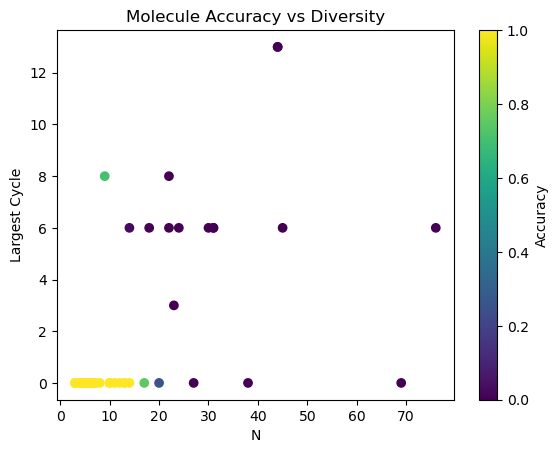

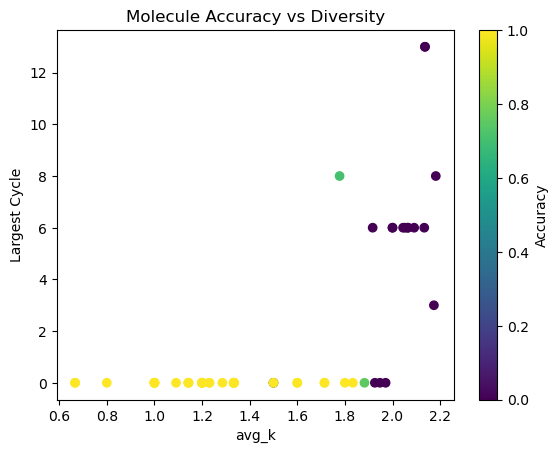

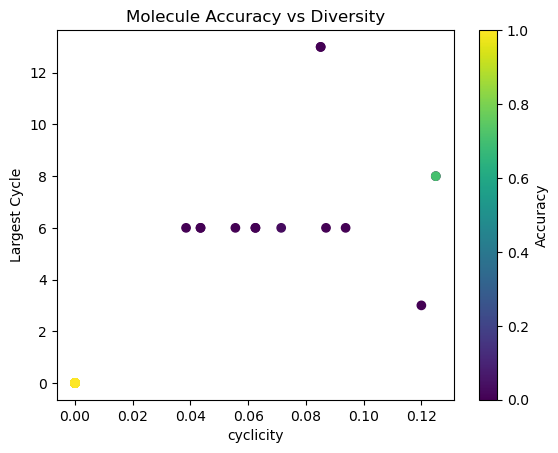

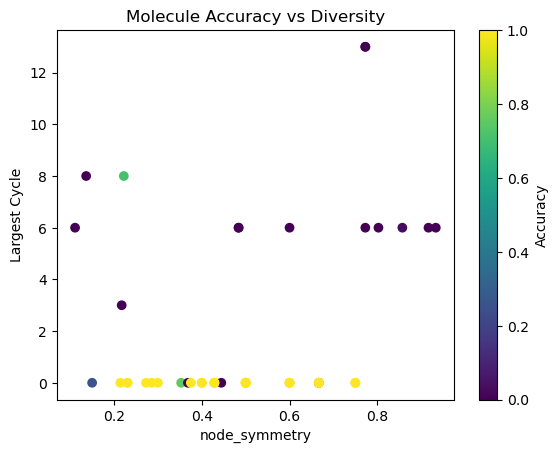

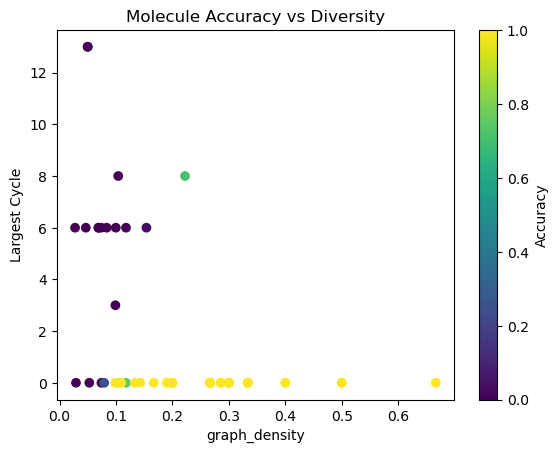

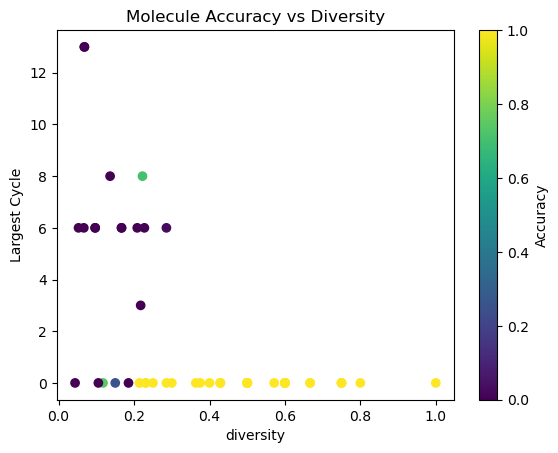

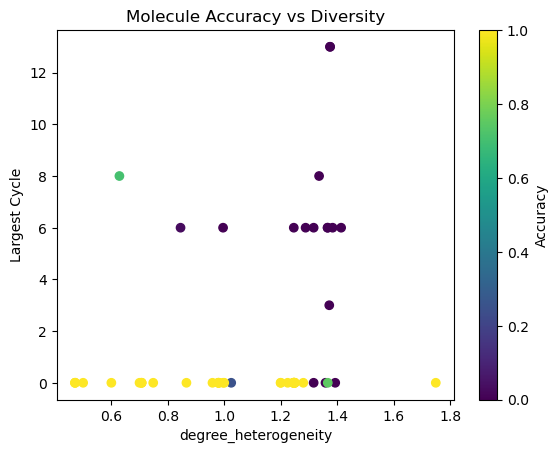

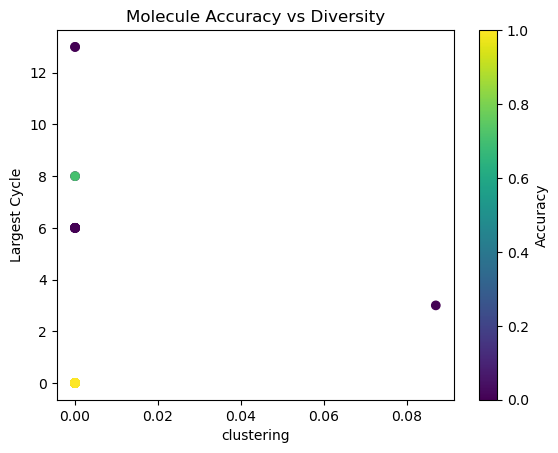

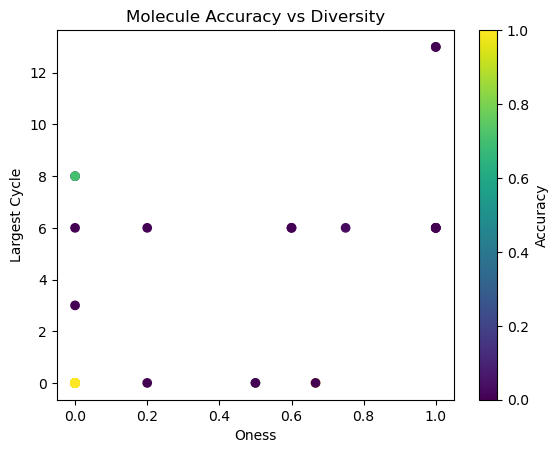

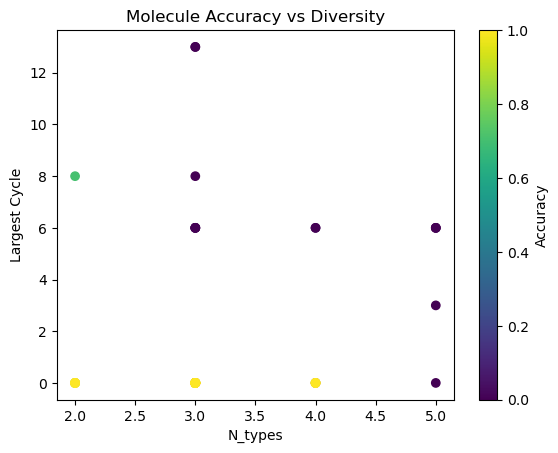

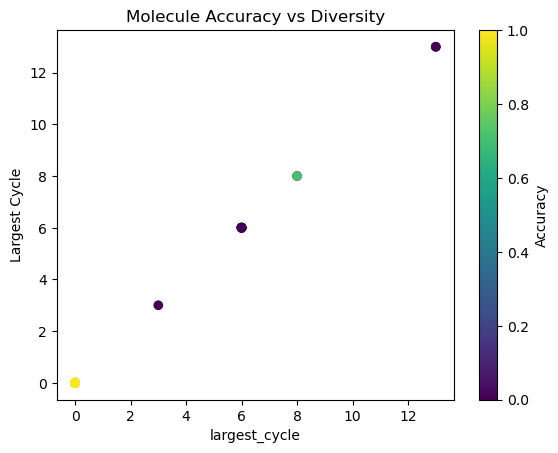

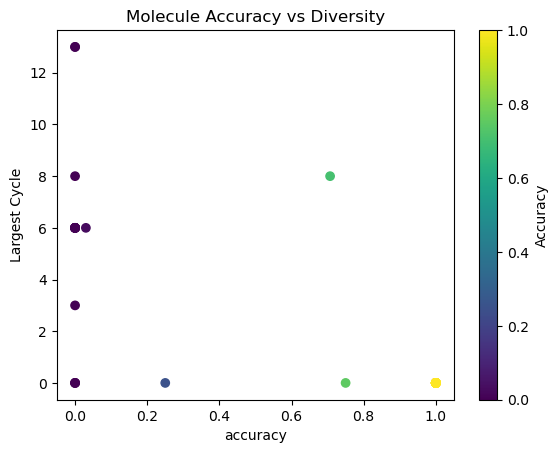

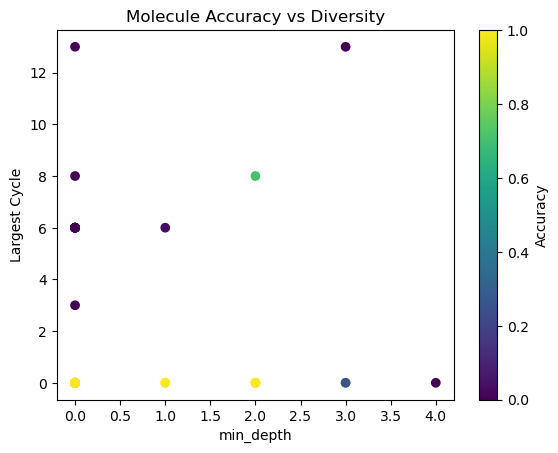

In [25]:
col = mol_df_indiv_nodes.columns
for c in col:
    plt.scatter(mol_df_indiv_nodes[c], mol_df_indiv_nodes['largest_cycle'], c=mol_df_indiv_nodes['accuracy'], cmap='viridis')
    plt.colorbar(label='Accuracy')
    plt.xlabel(c)
    plt.ylabel('Largest Cycle')
    plt.title('Molecule Accuracy vs Diversity')
    plt.show()

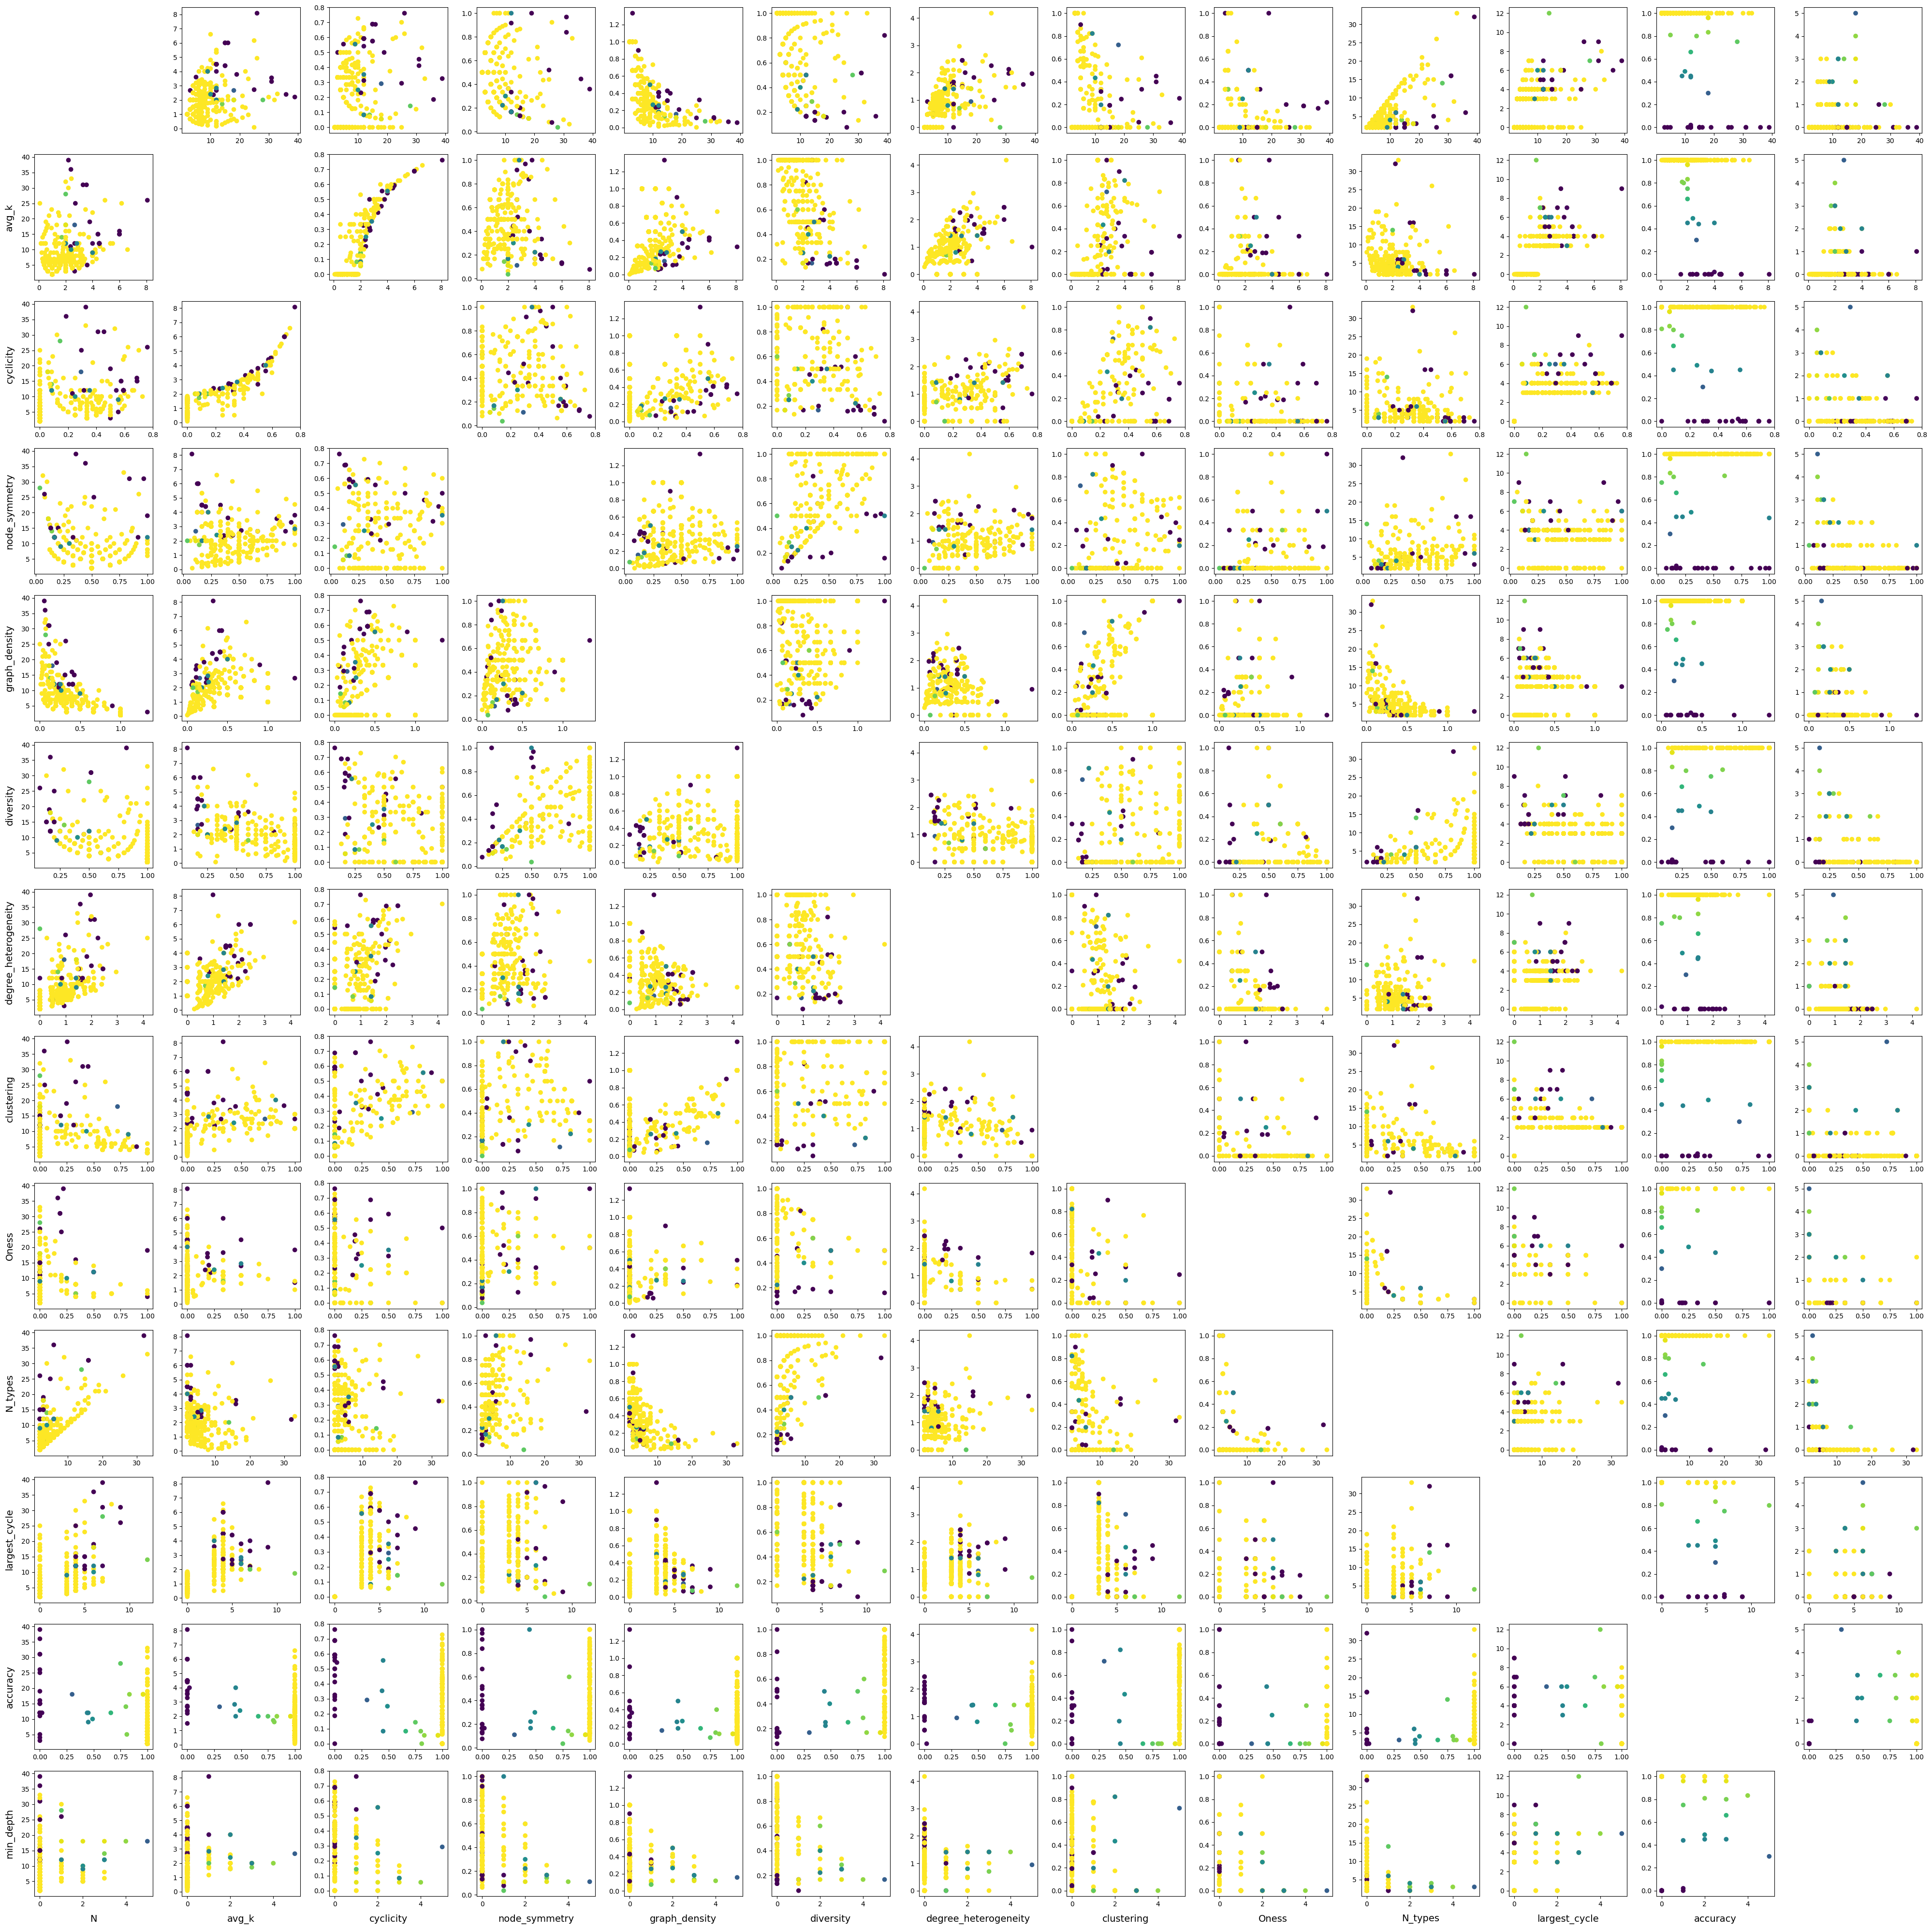

In [34]:
# NUmber of column combinations
col = protein_df_indiv_nodes.columns
# Scatter plot for each combination of columns
num_combinations = len(col) * (len(col) - 1) // 2
# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(col), ncols=len(col), figsize=(40, 40))
for i, c in enumerate(col):
    for j, d in enumerate(col):
        if i != j:  # Avoid plotting the same column against itself
            axs[i, j].scatter(protein_df_indiv_nodes[c], protein_df_indiv_nodes[d], c=protein_df_indiv_nodes['accuracy'], cmap='viridis')
        else:
            axs[i, j].axis('off')  # Turn off the subplot for diagonal elements

# Add labels to the subplots for rows and columns
for i, c in enumerate(col):
    axs[i, 0].set_ylabel(c, fontsize=14, labelpad=10)  # Label for the y-axis
    axs[-1, i].set_xlabel(c, fontsize=14, labelpad=10)  # Label for the x-axis

plt.tight_layout()
plt.show()

In [37]:
(mol_df_indiv_nodes['N'] - mol_df_indiv_nodes['N_types']) / mol_df_indiv_nodes['N']

basename
CID_10103319     0.814815
CID_10112        0.400000
CID_1031         0.750000
CID_1046         0.714286
CID_11029        0.400000
CID_1116159      0.903226
CID_11248        0.400000
CID_11358077     0.931818
CID_115056       0.903226
CID_11832956     0.931818
CID_118705487    0.791667
CID_119432       0.500000
CID_12620        0.956522
CID_12675        0.882353
CID_131839611    0.933333
CID_132477936    0.947368
CID_132935795    0.833333
CID_13916        0.772727
CID_14052        0.894737
CID_165565       0.850000
CID_168924       0.785714
CID_17358        0.714286
CID_23665760     0.000000
CID_23668193     0.250000
CID_23668197     0.250000
CID_24083        0.500000
CID_24243        0.625000
CID_24266        0.428571
CID_24393        0.500000
CID_24424        0.500000
CID_24436        0.571429
CID_24439        0.769231
CID_24456        0.769231
CID_24462        0.500000
CID_24470        0.400000
CID_24934        0.500000
CID_25960        0.571429
CID_280          0.333333
CID

In [1]:
protein_df

NameError: name 'protein_df' is not defined

In [9]:
protein_df[protein_df['basename'] == 'CPX-4742']

type  basename   N  avg_k  cyclicity  node_symmetry  graph_density  \
173033  human  CPX-4742  12    2.0   0.083333       0.166667       0.181818   

        diversity  degree_heterogeneity  clustering  Oness  N_types  \
173033       0.25              1.414214         0.0    0.0        3   

        largest_cycle  tree_num  depth  leaves  accuracy  min_depth  
173033              4         0      3       9      0.66        3.0